## Reading in packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import pathlib
import shutil
import tempfile
import vaex
from IPython import display
from IPython.display import clear_output
import pyodbc

# Tensorflow related
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow.compat.v2.feature_column as fc

#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print(tf.__version__)
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final,\
                                    generateFeatures_multi_final

from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing,\
                                                    extract_labels_multi_final,\
                                                    align_features_and_labels_multi_final,\
                                                    align_features_and_labels_multi_v5

from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction
from utils.plotting import plot_confusion_matrix

2.2.0
C:\Users\PC\AppData\Local\Temp\tmp7ltn02rb\tensorboard_logs


In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
# Do you wanna see?

# Setting up the Scalers!
mm_scaler = MinMaxScaler()
scaler = StandardScaler()
norm_scaler = Normalizer()
pt = PowerTransformer()
ptNst = PowerTransformer(standardize=False)
qtUni = QuantileTransformer(n_quantiles=100)
qtGau = QuantileTransformer(n_quantiles=100,output_distribution='normal')

## Extracting data

In [2]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
#     path = 'F:/AggregatedTAQ/round3'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    if int(file) <= 2:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = None,
                           names=['open','high','low','close',
                                  'spread_open','spread_high','spread_low','spread_close',
                                  'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                  'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                  'Ticker'])
        # Using the choice of the user to determine the correct market file
        key = re.split('[_.]',datafiles[int(file)])[-2]
        marketDataFile = [file for file in os.listdir(path+'/round5_market_tickers') if key in file]

        # Reading in the market data
        tempData = pd.read_csv(path+'/round5_market_tickers/'+marketDataFile[0]
                               ,header = None
                               ,names=['open','high','low','close',
                                      'spread_open','spread_high','spread_low','spread_close',
                                      'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                      'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                      'Ticker'])
        # Adding the market data to the ticker data
        data = pd.concat([data,tempData],axis=0)
    else:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = 0,
                           index_col=[0,1]
#                            names=['open','high','low','close',
#                                   'spread_open','spread_high','spread_low','spread_close',
#                                   'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
#                                   'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
#                                   'Ticker']
                          )
    
    # Lower casing all column names
#     data.columns = data.columns.str.lower()
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

# Reading in sector information
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

# Creating a table with stock information based on the tickers available in the data.
uniqueTickers = data.Ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable.head(10)

Which one do you want to load? 

0: aggregateTAQ_May2020_10sec (1).csv
1: aggregateTAQ_May2020_30sec (1).csv
2: aggregateTAQ_May2020_60sec.csv
8: trueAggregateTAQ_60sec.csv


8


C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticker,sector,exchange,marketCap
12,AAPL,Technology,NMS,1.578173e+12
20,ABBV,Healthcare,NYQ,1.742612e+11
34,ABT,Healthcare,NYQ,1.631410e+11
126,AEP,Utilities,NYQ,4.089551e+10
379,AMT,Real Estate,NYQ,1.171259e+11
428,APD,Basic Materials,NYQ,5.464395e+10
697,BA,Industrials,NYQ,1.020356e+11
699,BABA,Consumer Cyclical,NYQ,5.936536e+11
700,BAC,Financial Services,NYQ,2.020550e+11
870,BHP,Basic Materials,NYQ,1.258194e+11


# Testing the pipeline from Azure

In [3]:
# %%writefile $script_folder/train_nn_keras_v2.py
########## KERAS APPROACH #############

# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import numpy as np
import pandas as pd
import argparse
import os
import re
import time
import glob

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM, Dropout, Activation,LeakyReLU,Flatten
from keras.optimizers import RMSprop, Adam
from keras.callbacks import Callback
from keras.layers.normalization import BatchNormalization


import tensorflow as tf

# from azureml.core import Run

from utils.generate_features import generateFeatures_multi_final
from utils.preprocessing_features_and_labels import align_features_and_labels_multi_final, pre_processing


print("Keras version:", keras.__version__)
print("Tensorflow version:", tf.__version__)

# parser = argparse.ArgumentParser()
# parser.add_argument('--data-source', type=str, dest='data_source', default='data', help='data folder mounting point')
# parser.add_argument('--nn-type', type=str, dest='nn_type', default='ffnn', help='Choose the neural network type')
# parser.add_argument('--batch-size', type=int, dest='batch_size', default=128, help='mini batch size for training')
# parser.add_argument('--first-layer-neurons', type=int, dest='n_hidden_1', default=128,
#                     help='# of neurons in the first layer')
# parser.add_argument('--second-layer-neurons', type=int, dest='n_hidden_2', default=128,
#                     help='# of neurons in the second layer')
# parser.add_argument('--learning-rate', type=float, dest='learning_rate', default=0.01, help='learning rate')
# parser.add_argument('--dropout-ratio', type=float, dest='dropout_ratio', default=0.0, help='X_1')
# parser.add_argument('--n-layers', type=int, dest='n_layers', default=1, help='X_2')
# parser.add_argument('--l2-penalty', type=float, dest='l2_penalty', default=0.0, help='X_3')
# parser.add_argument('--batch-norm', type=int, dest='batch_norm', default=0, help='X_4')
# parser.add_argument('--batch-shuffle', type=int, dest='batch_shuffle', default=0, help='X_5')
# parser.add_argument('--activation-inner', type=str, dest='activation_inner', default='relu', help='X_6')
# parser.add_argument('--activation-output', type=str, dest='activation_output', default='softmax', help='X_7')

# ## Newly added
# parser.add_argument('--featureset', type=int, dest='feature_set',default=1, help='specifying the feature set')
# parser.add_argument('--pre-processing', type=str, dest = 'pre_processing',default=None, help='pre-processing of training and validation data')
# parser.add_argument('--feature-lags', type=int, dest='feature_lags', default=0, help='number of lagged features')
# parser.add_argument('--n-epochs', type=int, dest = 'n_epochs', default=20, help='number of epochs to run')
# parser.add_argument('--label-type', type=int, dest = 'label_type', default=1, help='label type')
# parser.add_argument('--pastobs-in-percentage', type=int, dest = 'pastobs_in_percentage', default=0, help='Option to specify if the pastobs feature should be in percentage')
# parser.add_argument('--resume-from', type=str, default=None,
#                     help='location of the model or checkpoint files from where to resume the training')
# args = parser.parse_args()

# previous_model_location = args.resume_from
n_feature_lags = 1
features_to_use = 1
pre_procesing_applied = 'quantgau'
n_epochs = 2
label_type = 2
pastobs_in_percentage = 1
nn_type = 'lstm'
dropout_ratio = 0.5
n_layers = 3
# l2_penalty = 
batch_norm = 1
batch_shuffle = 0
activation_inner = 'leakyrelu'
activation_output = 'softmax'
n_h1 = 128
n_h2 = 128
batch_size = 21450
learning_rate = 0.001

# start an Azure ML run
# run = Run.get_context()

# datasetName = 'aggregatedTAQ_60sec_wsectors'

# get the input dataset by name
# dataset = run.input_datasets[datasetName] # [data_source]

### load train and test set into numpy arrays
# load the TabularDataset to pandas DataFrame
# data = dataset.to_pandas_dataframe().set_index(['Column1','Column2'])
# data.columns = ['open','high','low','close','spread_open',
#                               'spread_high','spread_low','spread_close',
#                               'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
#                               'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
#                               'Ticker','sector']

# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF','SPY','DIA','QQQ']

# Extracting the sector ETFs to a separate variable
sectorETFS = data[data.Ticker.isin(etfs)]

# Removing the ETFs
data = data[~data.Ticker.isin(etfs)]



########### Generate Features ################

# feature_sets = {0:'base',
#                 1:'base with sectors',
#                 # 2:'technical',
#                 # 3:'technical with sectors'
#                 2:'base with technical',
#                 # 3:'base with techinical and sectors',
#                 3:'full'}

if features_to_use == 0:
    listOfFeatures = [
                        'pastobs',
                        'spread',
                        'bidsize',
                        'ofrsize',
                        'pastreturns',
                        'intradaytime'
                    ]

elif features_to_use == 1:

    listOfFeatures = [
                    'pastobs',
                    'spread',
                    'bidsize',
                    'ofrsize',
                    'pastreturns',
                    'intradaytime',
                    'sector'
                    ]

elif features_to_use == 2:
    listOfFeatures = [
                        'pastobs',
                        'spread',
                        'bidsize',
                        'ofrsize',
                        'pastreturns',
                        'intradaytime',
                        'stok',
                        'stod',
                        'sstod',
                        # 'wilr',
                        'roc',
                        'rsi',
                        'atr',
                        'cci',
                        'dpo',
                        'sma',
                        'ema',
                        'macd',
                        'macd_diff',
                        'macd_signal',
                        'dis5',
                        'dis10'
                        ]

elif features_to_use == 3:
 
    listOfFeatures = [
                    'pastobs',
                    'spread',
                    'bidsize',
                    'ofrsize',
                    'pastreturns',
                    'intradaytime',
                    'stok',
                    'stod',
                    'sstod',
                    # 'wilr',
                    'roc',
                    'rsi',
                    'atr',
                    'cci',
                    'dpo',
                    'sma',
                    'ema',
                    'macd',
                    'macd_diff',
                    'macd_signal',
                    'dis5',
                    'dis10',
                    'sector'
                    ]

elif features_to_use == 4:
    raise NotImplementedError
    ##

elif features_to_use == 5:
    raise NotImplementedError
    ##

elif features_to_use == 6:
    raise NotImplementedError

## Extracting the features

features = generateFeatures_multi_final(data = data, 
                                        listOfFeatures = listOfFeatures, 
                                        feature_lags = n_feature_lags,
                                        sectorETFS=sectorETFS,
                                        pastobs_in_percentage=pastobs_in_percentage)


########### Generate Labels ################

# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]

########### Align Data ################

# Label options:

'''
Label construction:
- Binary median split
	- positive/negative returns in our case, at 1 minute horizon.

- Multi 33-33-33 chunks

- Multi 20-60-20 chunks

- Multi 20-20-20-20-20 chunks

- Multi 10-20-40-20-10 chunks
'''

if label_type == 0:
    n_classes = 2
    label_split = [] # empty means equal split

elif label_type == 1:
    n_classes = 3
    label_split = [] # empty means equal split    

elif label_type == 2:
    n_classes = 3
    label_split = [0, 0.2, 0.8, 1] # for non-equal, include 0 and 1     

elif label_type == 3:
    n_classes = 5
    label_split = [] # empty means equal split        

elif label_type == 4:
    n_classes = 5
    label_split = [0, 0.1, 0.3, 0.7, 0.9, 1] # for non-equal, include 0 and 1

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y, indices = align_features_and_labels_multi_final(price_candles = price_candles, 
                                                        all_features = features,
                                                        prediction_horizon = 1, 
                                                        n_feature_lags = n_feature_lags, 
                                                        n_classes = n_classes, # 5,
                                                        label_split = label_split,
                                                        safe_burn_in = False, 
                                                        data_sample = 'full',
                                                        splitType='global',
                                                        noise=False,
                                                        ticker_dummies=False)


# Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='d_ticker', drop_first=False)], axis=1)

########### Splitting data ################

# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]]
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]]

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]]
y_test = y[tempIndices.days>=tempIndices.days.unique()[first_val_day]]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

training_set_size = X_train.shape[0]


# ########### Pre-processing: none right now ################

# if  pre_procesing_applied == 'None':
#     # do nothing here
#     pass

# elif  pre_procesing_applied == 'std':

#     # Standardize some features
#     ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
#     # Keep some in actual levels (Dummies in this case).
#     ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

#     # Merging the two
#     ppdict = {**ppdict1,**ppdict2}

#     # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

# elif pre_procesing_applied == 'minmax':

#     # splitpoint = int((args.feature-lags+1)*16)#32
#     # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

#     # Standardize some features
#     ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
#     # Keep some in actual levels (Dummies in this case).
#     ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

#     # Merging the two
#     ppdict = {**ppdict1,**ppdict2}

# elif pre_procesing_applied == 'pow':

#     # Standardize some features
#     ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
#     # Keep some in actual levels (Dummies in this case).
#     ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

#     # Merging the two
#     ppdict = {**ppdict1,**ppdict2}

# elif pre_procesing_applied == 'quantgau':

#     # Standardize some features
#     ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
#     # Keep some in actual levels (Dummies in this case).
#     ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

#     # Merging the two
#     ppdict = {**ppdict1,**ppdict2}

# elif pre_procesing_applied == 'individual':

#     # Keep some in actual levels (Dummies in this case).
#     ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

#     # Merging the two
#     ppdict = {**ppdict1,**ppdict2}

# elif pre_procesing_applied == 'stacked':
    
#     for j in ['pow','std','minmax']:

#         ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

#         # Keep some in actual levels (Dummies in this case).
#         ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

#         # Merging the two
#         ppdict = {**ppdict1,**ppdict2}

#         X_train,X_test = pre_processing(X_train,X_test,ppdict)

# if pre_procesing_applied not in ['None','stacked']:
#     X_train,X_test = pre_processing(X_train,X_test,ppdict)

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

# training_set_size = X_train.shape[0]

# n_inputs = X_train.shape[1] #28 * 28
# n_outputs = n_classes # 2 
# n_epochs = n_epochs# 20

# # one-hot encode a 1-D array
# def one_hot_encode(array, num_of_classes):
#     return np.eye(num_of_classes)[array.reshape(-1)]

# y_train = one_hot_encode(y_train.values.astype(np.int), n_outputs)
# y_test = one_hot_encode(y_test.values.astype(np.int), n_outputs)

# print('Shapes after one-hot-encoding labels')
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

# if nn_type =='ffnn':
#     # Build a simple MLP model
#     model = Sequential()

#     for layer in np.arange(n_layers):
#         if layer == 0:
#             # first hidden layer
#             model.add(Dense(n_h1, input_shape=(n_inputs,)))#, activation=activation_inner
            
#             if batch_norm:
#                 model.add(BatchNormalization())
            
#             if activation_inner == 'leakyrelu':
#                 model.add(LeakyReLU())
#             else:
#                 model.add(Activation(activation_inner))
#             # dropout
#             if dropout_ratio > 0:
#                 model.add(Dropout(dropout_ratio))
#         else:

#             # second hidden layer
#             model.add(Dense(n_h2))
#             if batch_norm:
#                 model.add(BatchNormalization())
            
#             if activation_inner == 'leakyrelu':
#                 model.add(LeakyReLU())
#             else:
#                 model.add(Activation(activation_inner))

#             # dropout
#             if dropout_ratio > 0:
#                 model.add(Dropout(dropout_ratio))

    
#     # output layer
#     model.add(Dense(n_outputs))
    
#     if batch_norm:
#         model.add(BatchNormalization())
            
#     model.add(Activation(activation_output))

# elif nn_type == 'lstm':
    
#     # LSTM Data Prep
#     # reshape input to be 3D [samples, timesteps, features]
#     X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
#     X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
#     # LSTM
#     model = Sequential()

#     for layer in np.arange(n_layers):

#         if layer==0:

#             #Adding the first LSTM layer and some Dropout regularisation
#             # model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
#             model.add(LSTM(units = n_h1//2, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2]))) # KRISNI: changed X_train.shape[1] to X_train.shape[0] - Update: Changed it back
            
#             if batch_norm:
#                 model.add(BatchNormalization())
            
#             # model.add(Activation(activation_inner))

#             # dropout
#             if dropout_ratio > 0:
#                 model.add(Dropout(dropout_ratio))

#         elif layer < (n_layers-1):
#             # Adding a second LSTM layer and some Dropout regularisation
#             model.add(LSTM(units = n_h2//2, return_sequences = True))
#             if batch_norm:
#                 model.add(BatchNormalization())
            
#             # model.add(Activation(activation_inner))

#             # dropout
#             if dropout_ratio > 0:
#                 model.add(Dropout(dropout_ratio))

#         else:
#             # Adding a second LSTM layer and some Dropout regularisation
#             model.add(LSTM(units = n_h2//2, return_sequences = False))
#             if batch_norm:
#                 model.add(BatchNormalization())
            
#             # model.add(Activation(activation_inner))

#             # dropout
#             if dropout_ratio > 0:
#                 model.add(Dropout(dropout_ratio))

#     # Adding the output layer
# #     model.add(Flatten()) # New - to combat the latest error, logged in azure-to-do file
#     model.add(Dense(units = n_outputs))

#     if batch_norm:
#         model.add(BatchNormalization())
            
#     model.add(Activation(activation_output))


# model.summary()

# model.compile(loss='categorical_crossentropy', #'sparse_categorical_crossentropy',
#               optimizer=Adam(lr=learning_rate),
#               metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']) #metrics = ['accuracy']) #) # #

# # start an Azure ML run
# # run = Run.get_context()


# class LogRunMetrics(Callback):
#     # callback at the end of every epoch
#     def on_epoch_end(self, epoch, log):
#         # log a value repeated which creates a list
#         run.log('Loss', log['val_loss'])
#         run.log('Accuracy', log['val_accuracy'])
#         run.log('AUC', log['val_auc'])

#         run.log('Train Loss', log['loss'])
#         run.log('Train Accuracy', log['accuracy'])
#         run.log('Train AUC', log['auc'])        


# history = model.fit(X_train, y_train,
#                     batch_size=batch_size,
#                     epochs=n_epochs,
#                     verbose=2,
#                     validation_data=(X_test, y_test),
# #                     callbacks=[LogRunMetrics()],
# #                     shuffle=batch_shuffle
#                     )

# score = model.evaluate(X_test, y_test, verbose=0)

# print("Scores", score)

# # # log a single value
# # run.log("Final test loss", score[0])
# print('Test loss:', score[0])

# # run.log('Final test AUC', score[1])
# print('Test AUC:', score[1])

# # run.log('Final test accuracy', score[2])
# print('Test accuracy:', score[2])

# # # log an image
# # run.log_image('Accuracy vs Loss', plot=plt)

# # create a ./outputs/model folder in the compute target
# # files saved in the "./outputs" folder are automatically uploaded into run history
# os.makedirs('./outputs/model', exist_ok=True)

# # serialize NN architecture to JSON
# model_json = model.to_json()
# # save model JSON
# with open('./outputs/model/model.json', 'w') as f:
#     f.write(model_json)
# # save model weights
# model.save_weights('./outputs/model/model.h5')
# print("model saved in ./outputs/model folder")



Keras version: 2.4.3
Tensorflow version: 2.2.0


INFO:MainThread:numexpr.utils:NumExpr defaulting to 4 threads.
C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


AAPL done
ABBV done
ABT done
AEP done
AMT done
APD done
BA done
BABA done
BAC done
BHP done
BP done
CCI done
CHL done
COST done
CSGP done
D done
DIS done
ECL done
ENB done
EXC done
FB done
FMX done
GOOG done
INTC done
JNJ done
KO done
LFC done
LIN done
LMT done
MA done
MCD done
MSFT done
NKE done
NVDA done
NVS done
Number of NaNs in label: 1. 1 is expected
Returns that lead to NaNs in label: [0.0907158]
PBR done
PEP done
PFE done
PLD done
PSA done
PTR done
PYPL done
RTX done
SHW done
SNP done
SO done
SRE done
T done
TM done
TSLA done
TSM done
UNP done
UPS done
V done
WMT done
(343200, 130)
(343200, 1)
(85690, 130)
(85690, 1)


In [91]:
########### Pre-processing: none right now ################

pre_procesing_applied = 'minmax'

if  pre_procesing_applied == 'None':
    # do nothing here
    pass

elif  pre_procesing_applied == 'std':

    # Standardize some features
    ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'minmax':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

elif pre_procesing_applied == 'pow':

    # Standardize some features
    ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

elif pre_procesing_applied == 'quantgau':

    # Standardize some features
    ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

elif pre_procesing_applied == 'individual':

    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

elif pre_procesing_applied == 'stacked':
    
    for j in ['pow','std','minmax']:

        ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

        X_train,X_test = pre_processing(X_train,X_test,ppdict)

if pre_procesing_applied not in ['None','stacked']:
    X_train_mm,X_test_mm = pre_processing(X_train.reset_index(drop=True),
                                          X_test.reset_index(drop=True),
                                              ppdict)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(343200, 130)
(343200, 1)
(85690, 130)
(85690, 1)


In [6]:
np.array(X_train.columns)

array(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0',
       'spread_open_lag0', 'spread_high_lag0', 'spread_low_lag0',
       'spread_close_lag0', 'bidsize_open_lag0', 'bidsize_high_lag0',
       'bidsize_low_lag0', 'bidsize_close_lag0', 'ofrsize_open_lag0',
       'ofrsize_high_lag0', 'ofrsize_low_lag0', 'ofrsize_close_lag0',
       'pastreturns_lag0', 'intradaytime_lag0', 'relReturns_DIA_lag0',
       'relReturns_IDU_lag0', 'relReturns_IYC_lag0',
       'relReturns_IYE_lag0', 'relReturns_IYG_lag0',
       'relReturns_IYH_lag0', 'relReturns_IYJ_lag0',
       'relReturns_IYK_lag0', 'relReturns_IYM_lag0',
       'relReturns_IYR_lag0', 'relReturns_IYW_lag0',
       'relReturns_IYZ_lag0', 'relReturns_QQQ_lag0',
       'relReturns_SPY_lag0', 'open_lag1', 'high_lag1', 'low_lag1',
       'close_lag1', 'spread_open_lag1', 'spread_high_lag1',
       'spread_low_lag1', 'spread_close_lag1', 'bidsize_open_lag1',
       'bidsize_high_lag1', 'bidsize_low_lag1', 'bidsize_close_lag1',
       'o

In [90]:
X_train_mm.iloc[0:50,0]

0     0.465491
1     0.478662
2     0.459114
3     0.468554
4     0.455492
5     0.453163
6     0.471441
7     0.457083
8     0.489568
9     0.437419
10    0.447796
11    0.449256
12    0.455513
13    0.454598
14    0.464098
15    0.457083
16    0.461097
17    0.452823
18    0.451030
19    0.460515
20    0.442072
21    0.453689
22    0.450826
23    0.447327
24    0.446853
25    0.445335
26    0.455391
27    0.477744
28    0.479220
29    0.459769
30    0.457083
31    0.461118
32    0.465281
33    0.457083
34    0.460915
35    0.474429
36    0.448219
37    0.448282
38    0.458747
39    0.456300
40    0.452560
41    0.458391
42    0.460415
43    0.454093
44    0.457873
45         NaN
46         NaN
47         NaN
48         NaN
49         NaN
Name: open_lag0, dtype: float64

In [92]:
X_train_mm.iloc[0:50,0]

0     0.465491
1     0.364205
2     0.453753
3     0.469990
4     0.442559
5     0.332379
6     0.412442
7     0.444486
8     0.487443
9     0.457083
10    0.387090
11    0.448351
12    0.459662
13    0.441649
14    0.522879
15    0.474361
16    0.490110
17    0.432486
18    0.457083
19    0.433423
20    0.453336
21    0.428260
22    0.457957
23    0.452780
24    0.457083
25    0.451516
26    0.496441
27    0.466200
28    0.423008
29    0.468934
30    0.445003
31    0.424961
32    0.483206
33    0.396613
34    0.457083
35    0.427016
36    0.456697
37    0.475840
38    0.462895
39    0.733264
40    0.486078
41    0.408057
42    0.425887
43    0.457083
44    0.456039
45    0.476120
46    0.421639
47    0.462032
48    0.451260
49    0.515732
Name: open_lag0, dtype: float64

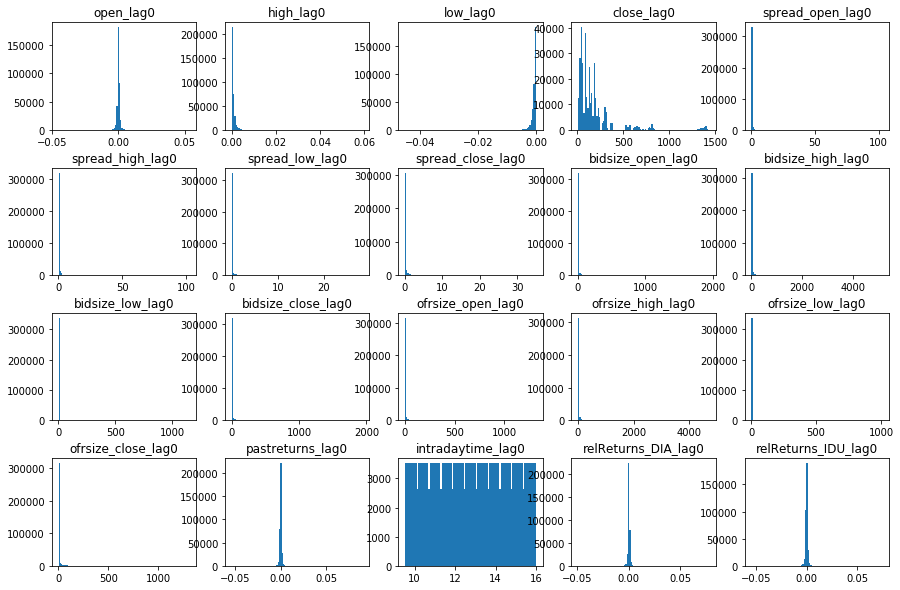

In [7]:
# Enter the form of plots you want to see, based on the total features to plota.
# A example: we have 32 features to plot, and the specified tupleOfPlotParameters is (4,4,2) resulting in 2 plots 
# showing 16 features each, and the individual features are plotted in 4x4 manner.
# dataToPlot = X_train[['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0',]]
tupleOfPlotParameters = (4,5,1)

# Creating a list of features to plot in each plot
# allFeaturesToPlot = np.arange(X.shape[1])
allFeaturesToPlot = np.arange(20)#X_train.shape[1]
allFeaturesToPlot = allFeaturesToPlot.reshape(tupleOfPlotParameters[2]
                                              ,int(20/tupleOfPlotParameters[2]))#X.shape[1]

for i in np.arange(0,tupleOfPlotParameters[2]):
#     plt.figure(figsize=(10,10))
#     for j in np.arange(tupleOfPlotParameters[1]):
    fig,ax = plt.subplots(tupleOfPlotParameters[0]
                      ,tupleOfPlotParameters[1]
                      ,figsize=(15,10))
    # Specifying the order to plot
    order = allFeaturesToPlot[i].reshape(tupleOfPlotParameters[0]
                                         ,tupleOfPlotParameters[1])
    
    for j in np.arange(order.shape[0]):
        
        for jj in np.arange(order.shape[1]):
            #print(j,jj)
            #print(X.iloc[:,0])
            ax[j,jj].hist(X_train.iloc[:,order[j,jj]]
                          ,bins = 100)
            ax[j,jj].set_title(X_train.columns[order[j,jj]])
    plt.subplots_adjust(hspace=0.35)
    plt.show()

C:\Users\PC\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\PC\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


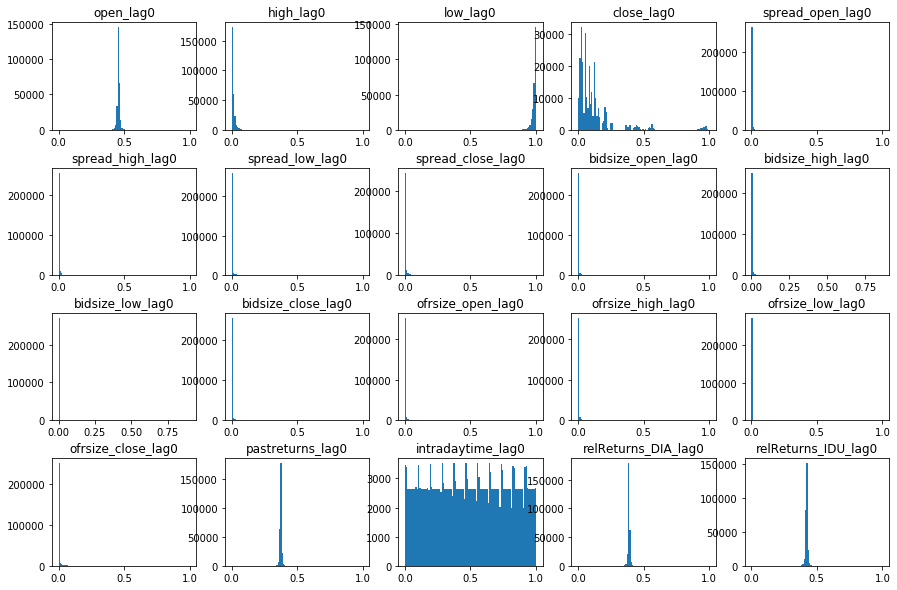

In [9]:
# Enter the form of plots you want to see, based on the total features to plot.
# A example: we have 32 features to plot, and the specified tupleOfPlotParameters is (4,4,2) resulting in 2 plots 
# showing 16 features each, and the individual features are plotted in 4x4 manner.
# dataToPlot = X_train[['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0',]]
tupleOfPlotParameters = (4,5,1)

# Creating a list of features to plot in each plot
# allFeaturesToPlot = np.arange(X.shape[1])
allFeaturesToPlot = np.arange(20)#X_train.shape[1]
allFeaturesToPlot = allFeaturesToPlot.reshape(tupleOfPlotParameters[2]
                                              ,int(20/tupleOfPlotParameters[2]))#X.shape[1]

for i in np.arange(0,tupleOfPlotParameters[2]):
#     plt.figure(figsize=(10,10))
#     for j in np.arange(tupleOfPlotParameters[1]):
    fig,ax = plt.subplots(tupleOfPlotParameters[0]
                      ,tupleOfPlotParameters[1]
                      ,figsize=(15,10))
    # Specifying the order to plot
    order = allFeaturesToPlot[i].reshape(tupleOfPlotParameters[0]
                                         ,tupleOfPlotParameters[1])
    
    for j in np.arange(order.shape[0]):
        
        for jj in np.arange(order.shape[1]):
            #print(j,jj)
            #print(X.iloc[:,0])
            ax[j,jj].hist(X_train_mm.iloc[:,order[j,jj]]
                          ,bins = 100)
            ax[j,jj].set_title(X_train_mm.columns[order[j,jj]])
    plt.subplots_adjust(hspace=0.35)
    plt.show()

In [21]:
print(np.where((np.sum(np.isinf(X_train.values), axis=1) == 0) == False))
print(np.where((np.sum(np.isnan(X_train.values), axis=1) == 0) == False))#X_train

(array([], dtype=int64),)
(array([], dtype=int64),)


In [93]:
print(np.where((np.sum(np.isinf(X_train_mm.values), axis=1) == 0) == False))
print(np.where((np.sum(np.isnan(X_train_mm.values), axis=1) == 0) == False))#X_train

(array([], dtype=int64),)
(array([], dtype=int64),)


In [14]:
np.where((np.sum(np.isnan(X_train_mm.values), axis=1) == 0) == False)[0].shape

(68552,)

In [18]:
X_train.iloc[45,0:30]

open_lag0               0.001880
high_lag0               0.002686
low_lag0               -0.001701
close_lag0             55.845000
spread_open_lag0        0.100000
spread_high_lag0        0.440000
spread_low_lag0         0.060000
spread_close_lag0       0.070000
bidsize_open_lag0       2.000000
bidsize_high_lag0      12.000000
bidsize_low_lag0        1.000000
bidsize_close_lag0      1.000000
ofrsize_open_lag0       2.000000
ofrsize_high_lag0       2.000000
ofrsize_low_lag0        1.000000
ofrsize_close_lag0      1.000000
pastreturns_lag0       -0.001787
intradaytime_lag0       9.533333
relReturns_DIA_lag0    -0.002268
relReturns_IDU_lag0    -0.000684
relReturns_IYC_lag0    -0.003736
relReturns_IYE_lag0    -0.009199
relReturns_IYG_lag0    -0.000765
relReturns_IYH_lag0    -0.002787
relReturns_IYJ_lag0    -0.001086
relReturns_IYK_lag0    -0.002127
relReturns_IYM_lag0    -0.002918
relReturns_IYR_lag0    -0.001314
relReturns_IYW_lag0    -0.003966
relReturns_IYZ_lag0    -0.001787
Name: 3509

In [22]:
X_train_mm.iloc[45,0:30]

open_lag0             NaN
high_lag0             NaN
low_lag0              NaN
close_lag0            NaN
spread_open_lag0      NaN
spread_high_lag0      NaN
spread_low_lag0       NaN
spread_close_lag0     NaN
bidsize_open_lag0     NaN
bidsize_high_lag0     NaN
bidsize_low_lag0      NaN
bidsize_close_lag0    NaN
ofrsize_open_lag0     NaN
ofrsize_high_lag0     NaN
ofrsize_low_lag0      NaN
ofrsize_close_lag0    NaN
pastreturns_lag0      NaN
intradaytime_lag0     NaN
relReturns_DIA_lag0   NaN
relReturns_IDU_lag0   NaN
relReturns_IYC_lag0   NaN
relReturns_IYE_lag0   NaN
relReturns_IYG_lag0   NaN
relReturns_IYH_lag0   NaN
relReturns_IYJ_lag0   NaN
relReturns_IYK_lag0   NaN
relReturns_IYM_lag0   NaN
relReturns_IYR_lag0   NaN
relReturns_IYW_lag0   NaN
relReturns_IYZ_lag0   NaN
Name: 45, dtype: float64

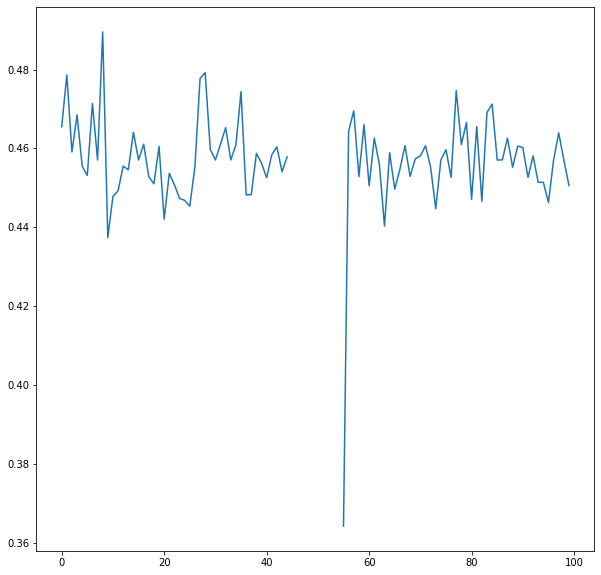

In [25]:
plt.figure(figsize=(10,10))
plt.plot(X_train_mm.iloc[0:100,0])
plt.show()

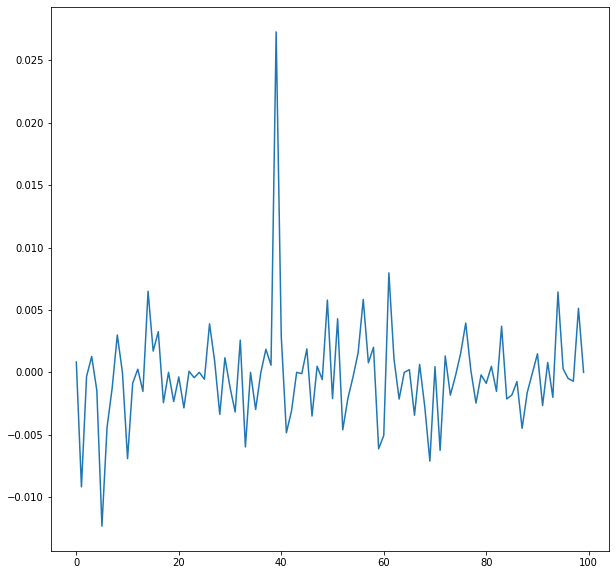

In [27]:
plt.figure(figsize=(10,10))
plt.plot(X_train.reset_index(drop=True).iloc[0:100,0])
plt.show()

In [54]:
key = []
item = []
# Extracting the items of the pre-processing dictonary
for k,i in ppdict.items():
    key.append(k)
    item.append(i)

# Numping
key = np.array(key)
item = np.array(item)

In [55]:
key,item

(array(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0',
        'spread_open_lag0', 'spread_high_lag0', 'spread_low_lag0',
        'spread_close_lag0', 'bidsize_open_lag0', 'bidsize_high_lag0',
        'bidsize_low_lag0', 'bidsize_close_lag0', 'ofrsize_open_lag0',
        'ofrsize_high_lag0', 'ofrsize_low_lag0', 'ofrsize_close_lag0',
        'pastreturns_lag0', 'intradaytime_lag0', 'relReturns_DIA_lag0',
        'relReturns_IDU_lag0', 'relReturns_IYC_lag0',
        'relReturns_IYE_lag0', 'relReturns_IYG_lag0',
        'relReturns_IYH_lag0', 'relReturns_IYJ_lag0',
        'relReturns_IYK_lag0', 'relReturns_IYM_lag0',
        'relReturns_IYR_lag0', 'relReturns_IYW_lag0',
        'relReturns_IYZ_lag0', 'relReturns_QQQ_lag0',
        'relReturns_SPY_lag0', 'open_lag1', 'high_lag1', 'low_lag1',
        'close_lag1', 'spread_open_lag1', 'spread_high_lag1',
        'spread_low_lag1', 'spread_close_lag1', 'bidsize_open_lag1',
        'bidsize_high_lag1', 'bidsize_low_lag1', 'bidsize_close_

In [56]:
key[item=='minmax']

array(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0',
       'spread_open_lag0', 'spread_high_lag0', 'spread_low_lag0',
       'spread_close_lag0', 'bidsize_open_lag0', 'bidsize_high_lag0',
       'bidsize_low_lag0', 'bidsize_close_lag0', 'ofrsize_open_lag0',
       'ofrsize_high_lag0', 'ofrsize_low_lag0', 'ofrsize_close_lag0',
       'pastreturns_lag0', 'intradaytime_lag0', 'relReturns_DIA_lag0',
       'relReturns_IDU_lag0', 'relReturns_IYC_lag0',
       'relReturns_IYE_lag0', 'relReturns_IYG_lag0',
       'relReturns_IYH_lag0', 'relReturns_IYJ_lag0',
       'relReturns_IYK_lag0', 'relReturns_IYM_lag0',
       'relReturns_IYR_lag0', 'relReturns_IYW_lag0',
       'relReturns_IYZ_lag0', 'relReturns_QQQ_lag0',
       'relReturns_SPY_lag0', 'open_lag1', 'high_lag1', 'low_lag1',
       'close_lag1', 'spread_open_lag1', 'spread_high_lag1',
       'spread_low_lag1', 'spread_close_lag1', 'bidsize_open_lag1',
       'bidsize_high_lag1', 'bidsize_low_lag1', 'bidsize_close_lag1',
       'o

In [57]:
key[item!='minmax']

array(['d_sector_Basic Materials', 'd_sector_Communication Services',
       'd_sector_Consumer Cyclical', 'd_sector_Consumer Defensive',
       'd_sector_Energy', 'd_sector_Financial Services',
       'd_sector_Healthcare', 'd_sector_Industrials',
       'd_sector_Real Estate', 'd_sector_Technology',
       'd_sector_Utilities', 'd_ticker_AAPL', 'd_ticker_ABBV',
       'd_ticker_ABT', 'd_ticker_AEP', 'd_ticker_AMT', 'd_ticker_APD',
       'd_ticker_BA', 'd_ticker_BABA', 'd_ticker_BAC', 'd_ticker_BHP',
       'd_ticker_BP', 'd_ticker_CCI', 'd_ticker_CHL', 'd_ticker_COST',
       'd_ticker_CSGP', 'd_ticker_D', 'd_ticker_DIS', 'd_ticker_ECL',
       'd_ticker_ENB', 'd_ticker_EXC', 'd_ticker_FB', 'd_ticker_FMX',
       'd_ticker_GOOG', 'd_ticker_INTC', 'd_ticker_JNJ', 'd_ticker_KO',
       'd_ticker_LFC', 'd_ticker_LIN', 'd_ticker_LMT', 'd_ticker_MA',
       'd_ticker_MCD', 'd_ticker_MSFT', 'd_ticker_NKE', 'd_ticker_NVDA',
       'd_ticker_NVS', 'd_ticker_PBR', 'd_ticker_PEP', 'd_ticker_P

In [36]:
len(key),len(item)

(130, 130)

In [52]:
rawData_train.columns.values

array(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0',
       'spread_open_lag0', 'spread_high_lag0', 'spread_low_lag0',
       'spread_close_lag0', 'bidsize_open_lag0', 'bidsize_high_lag0',
       'bidsize_low_lag0', 'bidsize_close_lag0', 'ofrsize_open_lag0',
       'ofrsize_high_lag0', 'ofrsize_low_lag0', 'ofrsize_close_lag0',
       'pastreturns_lag0', 'intradaytime_lag0', 'relReturns_DIA_lag0',
       'relReturns_IDU_lag0', 'relReturns_IYC_lag0',
       'relReturns_IYE_lag0', 'relReturns_IYG_lag0',
       'relReturns_IYH_lag0', 'relReturns_IYJ_lag0',
       'relReturns_IYK_lag0', 'relReturns_IYM_lag0',
       'relReturns_IYR_lag0', 'relReturns_IYW_lag0',
       'relReturns_IYZ_lag0', 'relReturns_QQQ_lag0',
       'relReturns_SPY_lag0', 'open_lag1', 'high_lag1', 'low_lag1',
       'close_lag1', 'spread_open_lag1', 'spread_high_lag1',
       'spread_low_lag1', 'spread_close_lag1', 'bidsize_open_lag1',
       'bidsize_high_lag1', 'bidsize_low_lag1', 'bidsize_close_lag1',
       'o

In [62]:
rawData_train = X_train.copy(deep=True).iloc[:,:]
rawData_test = X_test.copy(deep=True).iloc[:,:]
# ele = 'minmax'

# Creating an empty dataframe to store the pre-processed data.
pp_train = pd.DataFrame()
pp_test = pd.DataFrame()

for ele in np.unique(item):
        if verbose:
            print('Pre-Processing Procedure: ',ele,'\n\n')

        # Return the actual values
        if ele.lower() == 'act':
            print(key[item==ele],'\n\n')
            # Account for lags and preprocess all lags the same way
            cols = [[c for c in rawData_train.columns if t == c] for t in key[item==ele]]
            cols = np.concatenate(cols)
            print(cols,'\n\n')
            print(set(cols),'\n\n')
            if verbose:
                print('Columns Processed:',key[item==ele],'\n')

            # Adding the raw feature to the new frame
            pp_train[cols] = rawData_train[cols]
            pp_test[cols] = rawData_test[cols]
        
        elif ele.lower() == 'minmax':
            # Account for lags and preprocess all lags the same way
            cols = [[c for c in rawData_train.columns if ((t==c) | (t in c) & ('lag' in c))] for t in key[item==ele]]
            cols = np.concatenate(cols)
            #             print(cols)
            if verbose:
                print('Columns Processed:',key[item==ele],'\n')
            #             print(rawData_train[cols].values)
            #             print(rawData_train[cols].values.shape)
            #print(rawData_train[cols].values.reshape(-1,2))
            #print(rawData_train[cols].values.reshape(-1,2).shape)
            # Adding the transformed features to the new frame
            mm_scaler.fit(rawData_train[cols].values)# if len(cols) > 10 else mm_scaler.fit(rawData_train[cols].values.reshape(-1,1))
            #             print(pd.DataFrame(mm_scaler.transform(rawData_train[cols].values)))
            pp_train[cols] = pd.DataFrame(mm_scaler.transform(rawData_train[cols].values))#,columns=cols# if len(cols) > 10 else pd.DataFrame(mm_scaler.transform(rawData_train[cols].values.reshape(-1,1)))
            #             print(pp_train)
            #             print(pd.DataFrame(mm_scaler.transform(rawData_test[cols].values)))
            pp_test[cols] = pd.DataFrame(mm_scaler.transform(rawData_test[cols].values))#,columns = cols#if len(cols) > 10 else pd.DataFrame(mm_scaler.transform(rawData_test[cols].values.reshape(-1,1)))

Pre-Processing Procedure:  act 


['d_sector_Basic Materials' 'd_sector_Communication Services'
 'd_sector_Consumer Cyclical' 'd_sector_Consumer Defensive'
 'd_sector_Energy' 'd_sector_Financial Services' 'd_sector_Healthcare'
 'd_sector_Industrials' 'd_sector_Real Estate' 'd_sector_Technology'
 'd_sector_Utilities' 'd_ticker_AAPL' 'd_ticker_ABBV' 'd_ticker_ABT'
 'd_ticker_AEP' 'd_ticker_AMT' 'd_ticker_APD' 'd_ticker_BA'
 'd_ticker_BABA' 'd_ticker_BAC' 'd_ticker_BHP' 'd_ticker_BP'
 'd_ticker_CCI' 'd_ticker_CHL' 'd_ticker_COST' 'd_ticker_CSGP'
 'd_ticker_D' 'd_ticker_DIS' 'd_ticker_ECL' 'd_ticker_ENB' 'd_ticker_EXC'
 'd_ticker_FB' 'd_ticker_FMX' 'd_ticker_GOOG' 'd_ticker_INTC'
 'd_ticker_JNJ' 'd_ticker_KO' 'd_ticker_LFC' 'd_ticker_LIN' 'd_ticker_LMT'
 'd_ticker_MA' 'd_ticker_MCD' 'd_ticker_MSFT' 'd_ticker_NKE'
 'd_ticker_NVDA' 'd_ticker_NVS' 'd_ticker_PBR' 'd_ticker_PEP'
 'd_ticker_PFE' 'd_ticker_PLD' 'd_ticker_PSA' 'd_ticker_PTR'
 'd_ticker_PYPL' 'd_ticker_RTX' 'd_ticker_SHW' 'd_ticker

In [74]:
# rawData_train = X_train.copy(deep=True).iloc[:,:]
# rawData_test = X_test.copy(deep=True).iloc[:,:]

rawData_train_1 = X_train.copy(deep=True).reset_index(drop=True).iloc[:,:]
rawData_test_1 = X_test.copy(deep=True).reset_index(drop=True).iloc[:,:]

#Creating an empty dataframe to store the pre-processed data.
pp_train = pd.DataFrame()
pp_test = pd.DataFrame()

# Pre-processing the data according to the desired ways.
for ele in np.unique(item):
    if verbose:
        print('Pre-Processing Procedure: ',ele)

    # Return the actual values
    if ele.lower() == 'act':

        # Account for lags and preprocess all lags the same way
#             cols = [[c for c in rawData_train.columns if t in c] for t in key[item==ele]]
        cols = [[c for c in rawData_train_1.columns if ((t==c) | (t in c) & ('lag' in c))] for t in key[item==ele]]
        cols = np.concatenate(cols)

        if verbose:
            print('Columns Processed:',key[item==ele],'\n')

        # Adding the raw feature to the new frame
        pp_train[cols] = rawData_train_1[cols]
        pp_test[cols] = rawData_test_1[cols]
        
        
    # Return the features min-max-normalised
    elif ele.lower() == 'minmax':

        # Account for lags and preprocess all lags the same way
        cols = [[c for c in rawData_train_1.columns if ((t==c) | (t in c) & ('lag' in c))] for t in key[item==ele]]
        cols = np.concatenate(cols)
#             print(cols)
        if verbose:
            print('Columns Processed:',key[item==ele],'\n')
#             print(rawData_train[cols].values)
#             print(rawData_train[cols].values.shape)
        #print(rawData_train[cols].values.reshape(-1,2))
        #print(rawData_train[cols].values.reshape(-1,2).shape)
        # Adding the transformed features to the new frame
        mm_scaler.fit(rawData_train_1[cols].values)# if len(cols) > 10 else mm_scaler.fit(rawData_train[cols].values.reshape(-1,1))
#             print(pd.DataFrame(mm_scaler.transform(rawData_train[cols].values)))
        pp_train[cols] = pd.DataFrame(mm_scaler.transform(rawData_train_1[cols].values))#,columns=cols# if len(cols) > 10 else pd.DataFrame(mm_scaler.transform(rawData_train[cols].values.reshape(-1,1)))
#             print(pp_train)
#             print(pd.DataFrame(mm_scaler.transform(rawData_test[cols].values)))
        pp_test[cols] = pd.DataFrame(mm_scaler.transform(rawData_test_1[cols].values))#,columns = cols#if len(cols) > 10 else pd.DataFrame(mm_scaler.transform(rawData_test[cols].values.reshape(-1,1)))

Pre-Processing Procedure:  act
Columns Processed: ['d_sector_Basic Materials' 'd_sector_Communication Services'
 'd_sector_Consumer Cyclical' 'd_sector_Consumer Defensive'
 'd_sector_Energy' 'd_sector_Financial Services' 'd_sector_Healthcare'
 'd_sector_Industrials' 'd_sector_Real Estate' 'd_sector_Technology'
 'd_sector_Utilities' 'd_ticker_AAPL' 'd_ticker_ABBV' 'd_ticker_ABT'
 'd_ticker_AEP' 'd_ticker_AMT' 'd_ticker_APD' 'd_ticker_BA'
 'd_ticker_BABA' 'd_ticker_BAC' 'd_ticker_BHP' 'd_ticker_BP'
 'd_ticker_CCI' 'd_ticker_CHL' 'd_ticker_COST' 'd_ticker_CSGP'
 'd_ticker_D' 'd_ticker_DIS' 'd_ticker_ECL' 'd_ticker_ENB' 'd_ticker_EXC'
 'd_ticker_FB' 'd_ticker_FMX' 'd_ticker_GOOG' 'd_ticker_INTC'
 'd_ticker_JNJ' 'd_ticker_KO' 'd_ticker_LFC' 'd_ticker_LIN' 'd_ticker_LMT'
 'd_ticker_MA' 'd_ticker_MCD' 'd_ticker_MSFT' 'd_ticker_NKE'
 'd_ticker_NVDA' 'd_ticker_NVS' 'd_ticker_PBR' 'd_ticker_PEP'
 'd_ticker_PFE' 'd_ticker_PLD' 'd_ticker_PSA' 'd_ticker_PTR'
 'd_ticker_PYPL' 'd_ticker_RTX' 'd_ticke

In [64]:
pp_train.iloc[0:50,0]

0         0
7798      0
15596     0
23394     1
31192     0
38990     0
46788     0
54586     0
62384     0
70182     0
77980     0
85778     0
93576     0
101374    0
109172    1
116970    0
124768    0
132566    0
140364    0
148162    0
155960    0
163758    0
171556    0
179354    0
187152    0
194950    1
202748    0
210546    0
218344    0
226142    0
233940    0
241738    0
249536    0
257334    0
265132    0
272930    0
280728    1
288526    0
296324    0
304122    0
311920    0
319718    0
327516    0
335314    0
343112    0
350910    0
358708    0
366506    1
374304    0
382102    0
Name: d_sector_Basic Materials, dtype: uint8

In [70]:
len(key[item=='act'])

66

In [66]:
# Rearanging columns before we return it
pp_train,pp_test = pp_train[rawData_train.columns],pp_test[rawData_test.columns]

In [68]:
pp_train.shape,pp_test.shape

((343200, 130), (85690, 130))

In [75]:
pp_train.iloc[0:55,66]

0     0.465491
1     0.364205
2     0.453753
3     0.469990
4     0.442559
5     0.332379
6     0.412442
7     0.444486
8     0.487443
9     0.457083
10    0.387090
11    0.448351
12    0.459662
13    0.441649
14    0.522879
15    0.474361
16    0.490110
17    0.432486
18    0.457083
19    0.433423
20    0.453336
21    0.428260
22    0.457957
23    0.452780
24    0.457083
25    0.451516
26    0.496441
27    0.466200
28    0.423008
29    0.468934
30    0.445003
31    0.424961
32    0.483206
33    0.396613
34    0.457083
35    0.427016
36    0.456697
37    0.475840
38    0.462895
39    0.733264
40    0.486078
41    0.408057
42    0.425887
43    0.457083
44    0.456039
45    0.476120
46    0.421639
47    0.462032
48    0.451260
49    0.515732
50    0.435845
51    0.500542
52    0.410492
53    0.435997
54    0.453320
Name: open_lag0, dtype: float64

In [73]:
X_train.loc[350910]

open_lag0            0.001880
high_lag0            0.002686
low_lag0            -0.001701
close_lag0          55.845000
spread_open_lag0     0.100000
                      ...    
d_ticker_TSM         0.000000
d_ticker_UNP         0.000000
d_ticker_UPS         0.000000
d_ticker_V           0.000000
d_ticker_WMT         0.000000
Name: 350910, Length: 130, dtype: float64

In [47]:
print(np.where((np.sum(np.isinf(pp_train.values), axis=1) == 0) == False))
print(np.where((np.sum(np.isnan(pp_train.values), axis=1) == 0) == False))#X_train

(array([], dtype=int64),)
(array([], dtype=int64),)


In [48]:
pp_train_1,pp_test_1 = pp_train[rawData_train.columns],pp_test[rawData_test.columns]

KeyError: "['d_sector_Consumer Cyclical', 'd_ticker_INTC', 'd_ticker_DIS', 'd_sector_Basic Materials', 'd_sector_Consumer Defensive', 'd_ticker_ABBV', 'd_ticker_JNJ', 'd_ticker_SNP', 'd_ticker_EXC', 'd_ticker_MA', 'd_ticker_COST', 'd_ticker_FMX', 'd_ticker_ENB', 'd_ticker_PBR', 'd_ticker_TM', 'd_ticker_AMT', 'd_ticker_BHP', 'd_ticker_NVS', 'd_ticker_NVDA', 'd_ticker_D', 'd_ticker_BAC', 'd_ticker_KO', 'd_ticker_SO', 'd_sector_Industrials', 'd_ticker_LMT', 'd_ticker_SHW', 'd_ticker_CSGP', 'd_ticker_MSFT', 'd_ticker_V', 'd_ticker_PLD', 'd_ticker_BABA', 'd_ticker_GOOG', 'd_ticker_CCI', 'd_ticker_BA', 'd_sector_Energy', 'd_sector_Technology', 'd_ticker_ABT', 'd_ticker_FB', 'd_ticker_AAPL', 'd_ticker_MCD', 'd_ticker_PFE', 'd_ticker_BP', 'd_ticker_PSA', 'd_ticker_PYPL', 'd_ticker_T', 'd_ticker_UNP', 'd_sector_Utilities', 'd_ticker_RTX', 'd_ticker_APD', 'd_ticker_TSLA', 'd_sector_Real Estate', 'd_ticker_LIN', 'd_ticker_WMT', 'd_ticker_LFC', 'd_ticker_SRE', 'd_sector_Healthcare', 'd_sector_Communication Services', 'd_ticker_TSM', 'd_ticker_AEP', 'd_ticker_PEP', 'd_sector_Financial Services', 'd_ticker_UPS', 'd_ticker_ECL', 'd_ticker_CHL', 'd_ticker_NKE', 'd_ticker_PTR'] not in index"

# Let's test that motherfucker!!!

In [76]:
hej = pd.DataFrame()

In [84]:
med = pd.DataFrame({'0':[1,2,3,4,5],'1':[1,2,3,4,5]})

In [85]:
med.index = [0,1,2,3,10]

In [86]:
med

,0,1
0,1,1
1,2,2
2,3,3
3,4,4
10,5,5


In [87]:
cols_1 = ['0','1']

In [88]:
hej[cols_1] = med[cols_1]

In [89]:
hej

,0,1
0,1,1
1,2,2
2,3,3
3,4,4
10,5,5


In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
y_test.shape

In [ ]:
y_train.shape

In [ ]:
stop


# reading in the market data (done automatically atm)

In [ ]:
file

In [ ]:
data

In [ ]:
data

In [ ]:
data.columns

### Dropping ETFS and market indices

In [ ]:
data.Ticker.unique()

In [ ]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

In [ ]:
data.Ticker.unique()

In [ ]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF','SPY','DIA','QQQ']

# Extracting the sector ETFs to a separate variable
sectorETFS = data[data.Ticker.isin(etfs)]

# Removing the ETFs
data = data[~data.Ticker.isin(etfs)]

In [ ]:
data.columns

In [ ]:
data

In [ ]:
########### Generate Features ################

n_feature_lags = 1

# features = generateFeatures_multi_final(data = data, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                       'macd_diff',
# #                                                       'macd_signal',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                       'sector'
#                                                    ], 
#                                    feature_lags = n_feature_lags
#                                      ,stockTable=stockTable)
features = generateFeatures_multi_final(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
                                                    'stok',
                                                    'stod',
                                                    'sstod',
#                                                     'wilr',
                                                    'roc',
                                                    'rsi',
                                                    'atr',
                                                    'cci',
                                                    'dpo',
                                                    'sma',
                                                    'ema',
                                                    'macd',
                                                      'macd_diff',
                                                      'macd_signal',
                                                    'dis5',
                                                    'dis10',
                                                      'sector'
                                                   ], 
                                   feature_lags = n_feature_lags
                                     ,sectorETFS=sectorETFS)

########### Generate Labels ################

n_classes = 2
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y,indices = align_features_and_labels_multi_final(price_candles = price_candles, 
                                                 all_features = features,
                                                 prediction_horizon = 1, 
                                                 n_feature_lags = n_feature_lags, 
                                                 n_classes = n_classes, # 5,
                                                 safe_burn_in = False, 
                                                 data_sample = 'full',
                                                 splitType='global',
                                                 noise=False,ticker_dummies=False)

## Splitting the data

## Adding ticker dummies

In [ ]:
## Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='ticker', drop_first=False)], axis=1)

In [ ]:
X.columns

## Constructing our final train/validation sets

In [ ]:
# train_ds = pd.concat([X.iloc[start:end, :] for (start, end) in train_ranges]).reset_index(drop=True)
# train_y = pd.concat([y.iloc[start:end] for (start, end) in train_ranges]).reset_index(drop=True)

# validate_ds = pd.concat([X.iloc[start:end, :] for (start, end) in val_ranges]).reset_index(drop=True)
# val_y = pd.concat([y.iloc[start:end] for (start, end) in val_ranges]).reset_index(drop=True)

# train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape, train_y.shape[0] + val_y.shape[0]

# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_test = y[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

In [ ]:
X_train

In [ ]:
np.where((np.sum(np.isinf(X_train.values), axis=1) == 0) == False),
np.where((np.sum(np.isnan(X_train.values), axis=1) == 0) == False)#X_train


## Pre-processing

In [ ]:
{i:colname for i,colname in enumerate(train_ds.columns)}

In [ ]:
# Creating one ppdict for individual preprocessings
# ppdict1 = {'open':'minmax',
#           'high':'log',
#           'low':'log',
#           'close':'std'}
# splitpoint = 32

# # Standardize some features
# ppdict1 = {i:'std' for i in train_ds.columns[0:splitpoint]} 
# # Keep some in actual levels (Dummies in this case).
# ppdict2 = {i:'act' for i in train_ds.columns[splitpoint:]}

pre_procesing_applied = 'std'

# Merging the two
# ppdict = {**ppdict1,**ppdict2}

if  pre_procesing_applied == 'None':
    # do nothing here
    pass

elif  pre_procesing_applied == 'std':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'minmax':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(X_train,X_test,pp_dict)

elif pre_procesing_applied == 'pow':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'quantgau':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'individual':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    # ppdict1 = {i:'power' for i in X_train.columns if 'd_' != i[0:2]}


    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'stacked':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    for j in ['pow','std','minmax']:

        ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

        X_train,X_test = pre_processing(X_train,X_test,ppdict)

if pre_procesing_applied not in ['None','stacked']:
    X_train,X_test = pre_processing(X_train,X_test,ppdict)

In [ ]:
ppX_train.iloc[:,0].mean(),ppX_train.iloc[:,0].std()

## Prepping for models

In [ ]:
N_VALIDATION = val_y.shape[0] #int(1e3)
N_TRAIN = train_y.shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 500

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X.shape[1]

N_TRAIN, N_VALIDATION, N_TRAIN + N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

## A Logistic Regression model in TF/Keras

In [ ]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(1,
                       input_shape=(FEATURES,),
                       activation='sigmoid',
                       kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_auc', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks(run_id = 'first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=0) #(val_features, val_labels))

In [ ]:
model.evaluate(validate_ds,  val_y, verbose=2)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%tensorboard --logdir logs